In [99]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [100]:
raw_train = pd.read_csv("./input/train.csv")
raw_test = pd.read_csv("./input/test.csv")

In [101]:
target = raw_train.target
whole = pd.concat([raw_train.drop("target", axis=1), raw_test], axis=0).reset_index(drop=True)

In [102]:
whole.isnull().sum().reset_index()

,index,0
0,first_active_month,1
1,card_id,0
2,feature_1,0
3,feature_2,0
4,feature_3,0


In [103]:
whole.first_active_month = pd.to_datetime(whole.first_active_month.fillna("2017-09"))
whole["elapsed_time"] = (datetime.datetime(2018, 2, 1) - whole.first_active_month).apply(lambda x:x.days)
whole["year"] = whole.first_active_month.apply(lambda x:x.year)
whole["month"] = whole.first_active_month.apply(lambda x:x.month)

whole["feature_1_1or4_flg"] = np.where(whole.feature_1 == 1, 1, 0) + np.where(whole.feature_1 == 4, 1, 0)

In [104]:
whole.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,year,month,feature_1_1or4_flg
0,2017-06-01,C_ID_92a2005557,5,2,1,245,2017,6,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,2017,1,1
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2016,8,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,2017,9,1
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,2017,11,1


In [105]:
h_trs = pd.read_csv("./input/historical_transactions.csv")
n_trs = pd.read_csv("./input/new_merchant_transactions.csv")
trs = pd.concat([h_trs, n_trs], axis=0).reset_index(drop=True)

trs.purchase_date = pd.to_datetime(trs.purchase_date)

In [106]:
trs.isnull().sum().reset_index()

,index,0
0,authorized_flag,0
1,card_id,0
2,city_id,0
3,category_1,0
4,installments,0
5,category_3,234081
6,merchant_category_id,0
7,merchant_id,164697
8,month_lag,0
9,purchase_amount,0


In [107]:
np.max(trs.purchase_date)

Timestamp('2018-04-30 23:59:59')

In [108]:
np.min(trs.purchase_date)

Timestamp('2017-01-01 00:00:08')

In [109]:
trs.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [110]:
def merge_process(df1, df2, on="card_id", how="left"):
    result = pd.merge(df1, df2, on=on, how=how)
    return result

In [111]:
df_transaction = trs.card_id.value_counts().reset_index()
df_transaction.columns = ["card_id", "transaction_num"]

- authorized_flag
    - Nの数
    - Nの割合
    - Nの時の平均purchase_amount

In [112]:
#Nの数
df_authorized_flag = trs[["authorized_flag", "card_id"]].copy()
df_authorized_flag.authorized_flag = df_authorized_flag.authorized_flag.replace({"Y":0, "N":1})
df_authorized = df_authorized_flag.groupby("card_id")["authorized_flag"].sum().reset_index()
df_authorized.columns = ["card_id", "authorized_N_count"]
print("Process N_count completed")

#Nの割合
df_transaction = merge_process(df_transaction, df_authorized)
df_transaction["authorized_N_percentage"] = 1.0 * df_transaction.authorized_N_count / df_transaction.transaction_num
print("Process N_percentage completed")


#Nの時の平均purchase_amount
df_authorized_N = trs[trs.authorized_flag == "N"][["card_id", "purchase_amount"]].copy()
df_authorized_N_amount = df_authorized_N.groupby("card_id")["purchase_amount"].median().reset_index()
df_authorized_N_amount.columns = ["card_id", "authorized_N_median_purchase_amount"]
print("Process median_purchase_amount_N completed")

#Yの時の平均purchase_amount
df_authorized_Y = trs[trs.authorized_flag == "Y"][["card_id", "purchase_amount"]].copy()
df_authorized_Y_amount = df_authorized_N.groupby("card_id")["purchase_amount"].median().reset_index()
df_authorized_Y_amount.columns = ["card_id", "authorized_Y_median_purchase_amount"]
print("Process median_purchase_amount_Y completed")

df_authorized_amount = merge_process(df_authorized_N_amount, df_authorized_Y_amount)


df_transaction = merge_process(df_transaction, df_authorized_amount)
df_transaction.authorized_N_median_purchase_amount = df_transaction.authorized_N_median_purchase_amount.fillna(0)
df_transaction.authorized_Y_median_purchase_amount = df_transaction.authorized_Y_median_purchase_amount.fillna(0)
print("Process merge & fillna completed")

Process N_count completed
Process N_percentage completed
Process median_purchase_amount_N completed
Process median_purchase_amount_Y completed
Process merge & fillna completed


- city_id
    - 最大件数のid

In [113]:
df_city_pivot = pd.pivot_table(
    trs[["card_id", "city_id", "installments"]], 
    values = "installments",  
    columns="city_id", 
    index="card_id", 
    aggfunc="count", 
    fill_value=0
).reset_index()
print("Process pivot completed")

list_city = df_city_pivot.columns.tolist()[1:]
df_city_pivot["user_city_idx"] = np.argmax(df_city_pivot.as_matrix()[:, 1:], axis=1)
df_city_pivot["user_city"] = df_city_pivot.user_city_idx.apply(lambda x:list_city[x])
df_city = df_city_pivot[["card_id", "user_city"]]
print("Process city-select completed")

df_transaction = merge_process(df_transaction, df_city)

Process pivot completed
Process city-select completed


- category_1
    - Nの数
    - Nの割合
    - Nの時の平均purchase_amount
    - Yの時の平均purchase_amount

In [114]:
#Nの数
df_category1_flag = trs[["category_1", "card_id"]].copy()
df_category1_flag.category_1 = df_category1_flag.category_1.replace({"Y":0, "N":1})
df_category1 = df_category1_flag.groupby("card_id")["category_1"].sum().reset_index()
df_category1.columns = ["card_id", "category1_N_count"]
print("Process N_count completed")


#Nの割合
df_transaction = merge_process(df_transaction, df_category1)
df_transaction["category1_N_percentage"] = 1.0 * df_transaction.category1_N_count / df_transaction.transaction_num
print("Process N_percentage completed")


#Nの時の平均purchase_amount
df_category1_N = trs[trs.category_1 == "N"][["card_id", "purchase_amount"]].copy()
df_category1_N_amount = df_category1_N.groupby("card_id")["purchase_amount"].median().reset_index()
df_category1_N_amount.columns = ["card_id", "category1_N_median_purchase_amount"]
print("Process median_purchase_amount_N completed")


#Yの時の平均purchase_amount
df_category1_Y = trs[trs.category_1 == "Y"][["card_id", "purchase_amount"]].copy()
df_category1_Y_amount = df_category1_N.groupby("card_id")["purchase_amount"].median().reset_index()
df_category1_Y_amount.columns = ["card_id", "category1_Y_median_purchase_amount"]
print("Process median_purchase_amount_Y completed")

df_category1_amount = merge_process(df_category1_N_amount, df_category1_Y_amount)


df_transaction = merge_process(df_transaction, df_category1_amount)
df_transaction.category1_N_median_purchase_amount = df_transaction.category1_N_median_purchase_amount.fillna(0)
df_transaction.category1_Y_median_purchase_amount = df_transaction.category1_Y_median_purchase_amount.fillna(0)
print("Process merge & fillna completed")

Process N_count completed
Process N_percentage completed
Process median_purchase_amount_N completed
Process median_purchase_amount_Y completed
Process merge & fillna completed


- installments
    - 0の割合
    - 1 ~ 3の割合
    - 4 ~ 6の割合
    - 6 ~ 9の割合
    - 10 ~ 12の割合

In [115]:
df_installments_pivot = pd.pivot_table(
    trs[["card_id", "installments", "purchase_amount"]], 
    values="purchase_amount", 
    columns="installments", 
    index="card_id", 
    aggfunc="count",  
    fill_value=0
).reset_index()
print("Process pivot completed")


df_installments_pivot["installments_0"] = df_installments_pivot[df_installments_pivot.columns[2]]
print("Process installment 0 completed")
df_installments_pivot["installments_1_3"] = np.sum(df_installments_pivot[df_installments_pivot.columns[3:6]].as_matrix(), axis=1)
print("Process installment 1~3 completed")
df_installments_pivot["installments_4_6"] = np.sum(df_installments_pivot[df_installments_pivot.columns[6:9]].as_matrix(), axis=1)
print("Process installment 4~6 completed")
df_installments_pivot["installments_7_9"] = np.sum(df_installments_pivot[df_installments_pivot.columns[9:12]].as_matrix(), axis=1)
print("Process installment 7~9 completed")
df_installments_pivot["installments_10_12"] = np.sum(df_installments_pivot[df_installments_pivot.columns[12:15]].as_matrix(), axis=1)
print("Process installment 10~12 completed")
df_installments_pivot["installments_else"] = df_installments_pivot[df_installments_pivot.columns[1]] + df_installments_pivot[df_installments_pivot.columns[15]]
print("Process installment else completed")

df_installments = df_installments_pivot[[
    "card_id",
    "installments_0", 
    "installments_1_3",
    "installments_4_6",
    "installments_7_9",
    "installments_10_12",
    "installments_else"
]]

installments_sum_per_card = np.sum(df_installments[df_installments.columns[1:]].as_matrix(), axis=1)
for col in df_installments.columns[1:]:
    percentage_col_name = col + "_percentage"
    df_installments[percentage_col_name] = df_installments[col] / installments_sum_per_card
print("Process percentage completed")

df_transaction = merge_process(df_transaction, df_installments)
print("Process merge completed")

Process pivot completed
Process installment 0 completed
Process installment 1~3 completed
Process installment 4~6 completed
Process installment 7~9 completed
Process installment 10~12 completed
Process installment else completed
Process percentage completed
Process merge completed


- category_3
    - 欠損の数
    - Aの数
    - Bの数
    - Cの数

In [116]:
df_category3_pivot = pd.pivot_table(
    trs[["card_id", "category_3", "purchase_amount"]],
    values="purchase_amount",
    columns="category_3",
    index="card_id",
    aggfunc="count",
    fill_value=0
).reset_index()
df_category3_pivot.columns = ["card_id", "category3_A", "category3_B", "category3_C"]
print("Process pivot completed")

df_category3_nan = trs[["card_id", "category_3"]].copy()
df_category3_nan["category3_Nan_flg"] = np.where(df_category3_nan.category_3.isnull(), 1, 0)
df_category3 = df_category3_nan.groupby("card_id")["category3_Nan_flg"].sum().reset_index()
df_category3.columns = ["card_id", "category3_NaN_count"]
print("Process NaN completed")

df_category3 = merge_process(df_category3, df_category3_pivot)

df_transaction = merge_process(df_transaction, df_category3)
print("Process merge completed")

Process pivot completed
Process NaN completed
Process merge completed


- month_lag
    - それぞれの期間でのレコード数

In [117]:
df_month_lag = pd.pivot_table(
    trs[["card_id", "month_lag", "purchase_amount"]], 
    values="purchase_amount", 
    columns="month_lag", 
    index="card_id", 
    aggfunc="count",
    fill_value=0
).reset_index()
df_month_lag.columns = ["card_id"] + ["month_lag_{}".format(col) for col in df_month_lag.columns[1:]]
print("Process pivot completed")

df_transaction = merge_process(df_transaction, df_month_lag)
print("Process merge completed")

Process pivot completed
Process merge completed


- purchase_amount
    - 平均
    - max
    - min
    - var

In [118]:
df_purchase_amount = trs.groupby("card_id")["purchase_amount"].median().reset_index()
df_purchase_amount.columns = ["card_id", "purcahse_amount_median"]
print("Process median completed")

df_purchase_amount_max = trs.groupby("card_id")["purchase_amount"].max().reset_index()
df_purchase_amount_max.columns = ["card_id", "purcahse_amount_max"]
df_purchase_amount = merge_process(df_purchase_amount, df_purchase_amount_max)
print("Process max completed")

df_purchase_amount_min = trs.groupby("card_id")["purchase_amount"].min().reset_index()
df_purchase_amount_min.columns = ["card_id", "purcahse_amount_min"]
df_purchase_amount = merge_process(df_purchase_amount, df_purchase_amount_min)
print("Process max completed")

df_purchase_amount_std = trs.groupby("card_id")["purchase_amount"].std().reset_index()
df_purchase_amount_std.columns = ["card_id", "purcahse_amount_std"]
df_purchase_amount = merge_process(df_purchase_amount, df_purchase_amount_std)
print("Process statics completed")

df_transaction = merge_process(df_transaction, df_purchase_amount)
print("Process merge completed")

Process median completed
Process max completed
Process max completed
Process statics completed
Process merge completed


- purchase_date
    - max
    - min
    - 2018年頻度
    - 2018年4月頻度

In [119]:
df_purchase_date_all = trs[["card_id", "purchase_date"]].copy()
df_purchase_date = df_purchase_date_all.groupby("card_id")["purchase_date"].max().reset_index()
df_purchase_date.columns = ["card_id", "purchase_date_ratest"]
df_purchase_date.purchase_date_ratest = (datetime.datetime(2018, 5, 1) - df_purchase_date.purchase_date_ratest).apply(lambda x:x.days)
print("Process max completed")

df_purchase_date_min = df_purchase_date_all.groupby("card_id")["purchase_date"].min().reset_index()
df_purchase_date_min.columns = ["card_id", "purchase_date_oldest"]
df_purchase_date_min.purchase_date_oldest = (datetime.datetime(2018, 5, 1) - df_purchase_date_min.purchase_date_oldest).apply(lambda x:x.days)
df_purchase_date = merge_process(df_purchase_date, df_purchase_date_min)
print("Process min completed")

df_purchase_date["diff_purchase_date"] = df_purchase_date.purchase_date_oldest - df_purchase_date.purchase_date_ratest
print("Process diff completed")

df_purchase_date_2018 = df_purchase_date_all[df_purchase_date_all.purchase_date >= "2018-01-01"]
df_purchase_count_2018 = df_purchase_date_2018.groupby("card_id")["purchase_date"].count().reset_index()
df_purchase_count_2018.columns = ["card_id", "frequency_2018"]
df_purchase_date = merge_process(df_purchase_date, df_purchase_count_2018)
df_purchase_date.frequency_2018 = df_purchase_date.frequency_2018.fillna(0)
print("Process frequency_2018 completed")

df_purchase_date_201804 = df_purchase_date_all[df_purchase_date_all.purchase_date >= "2018-04-01"]
df_purchase_count_201804 = df_purchase_date_201804.groupby("card_id")["purchase_date"].count().reset_index()
df_purchase_count_201804.columns = ["card_id", "frequency_201804"]
df_purchase_date = merge_process(df_purchase_date, df_purchase_count_201804)
df_purchase_date.frequency_201804 = df_purchase_date.frequency_201804.fillna(0)
print("Process frequency_201804 completed")

df_purchase_date_201803 = df_purchase_date_all[(df_purchase_date_all.purchase_date >= "2018-03-01")&(df_purchase_date_all.purchase_date<"2018-04-01")]
df_purchase_count_201803 = df_purchase_date_201803.groupby("card_id")["purchase_date"].count().reset_index()
df_purchase_count_201803.columns = ["card_id", "frequency_201803"]
df_purchase_date = merge_process(df_purchase_date, df_purchase_count_201803)
df_purchase_date.frequency_201803 = df_purchase_date.frequency_201803.fillna(0)
print("Process frequency_201803 completed")

df_purchase_date_201802 = df_purchase_date_all[(df_purchase_date_all.purchase_date >= "2018-02-01")&(df_purchase_date_all.purchase_date<"2018-03-01")]
df_purchase_count_201802 = df_purchase_date_201802.groupby("card_id")["purchase_date"].count().reset_index()
df_purchase_count_201802.columns = ["card_id", "frequency_201802"]
df_purchase_date = merge_process(df_purchase_date, df_purchase_count_201802)
df_purchase_date.frequency_201802 = df_purchase_date.frequency_201802.fillna(0)
print("Process frequency_201802 completed")

df_purchase_date_201801 = df_purchase_date_all[(df_purchase_date_all.purchase_date >= "2018-01-01")&(df_purchase_date_all.purchase_date<"2018-02-01")]
df_purchase_count_201801 = df_purchase_date_201801.groupby("card_id")["purchase_date"].count().reset_index()
df_purchase_count_201801.columns = ["card_id", "frequency_201801"]
df_purchase_date = merge_process(df_purchase_date, df_purchase_count_201801)
df_purchase_date.frequency_201801 = df_purchase_date.frequency_201801.fillna(0)
print("Process frequency_201801 completed")

df_transaction = merge_process(df_transaction, df_purchase_date)
print("Process merge completed")

Process max completed
Process min completed
Process diff completed
Process frequency_2018 completed
Process frequency_201804 completed
Process frequency_201803 completed
Process frequency_201802 completed
Process frequency_201801 completed
Process merge completed


最新日の購入金額

In [120]:
df_purchase_ratest = df_purchase_date_all.groupby("card_id")["purchase_date"].max().reset_index()
print("Process groupby completed")

df_purchase_ratest_amount = pd.merge(
    trs[["card_id", "purchase_date", "purchase_amount"]],
    df_purchase_ratest, 
    on=["purchase_date", "card_id"],
    how="left"
)[["card_id", "purchase_amount"]]

df_ratest_amount =  df_purchase_ratest_amount.groupby("card_id")["purchase_amount"].max().reset_index()
df_ratest_amount.columns = ["card_id", "ratest_purchase_amount"]
print("Process extract ratest amount completed")


df_transaction = merge_process(df_transaction, df_ratest_amount)
print("Process merge completed")

Process groupby completed
Process extract ratest amount completed
Process merge completed


- category_2
    - それぞれの数
    - 割合

In [121]:
df_category2_pivot = pd.pivot_table(
    trs[["card_id", "category_2", "purchase_amount"]], 
    values="purchase_amount", 
    columns="category_2",
    index="card_id", 
    aggfunc="count", 
    fill_value=0
).reset_index()
df_category2_pivot.columns = ["card_id"] + ["category2_{}".format(col) for col in df_category2_pivot.columns[1:]]
print("Process pivot completed")

category2_sum = np.sum(df_category2_pivot.as_matrix()[:, 1:], axis=1)
for col in df_category2_pivot.columns[1:]:
    percentage_col_name = col + "_percentage"
    df_category2_pivot[percentage_col_name] = df_category2_pivot[col] / category2_sum
print("Process percentage completed")

df_transaction = merge_process(df_transaction, df_category2_pivot)
df_transaction = df_transaction.fillna(0)
print("Process merge completed")

Process pivot completed
Process percentage completed
Process merge completed


- state_id
    - 最大件数のid

In [122]:
df_state_pivot = pd.pivot_table(
    trs[["card_id", "state_id", "installments"]], 
    values = "installments",  
    columns="state_id", 
    index="card_id", 
    aggfunc="count", 
    fill_value=0
).reset_index()
print("Process pivot completed")

list_state = df_state_pivot.columns.tolist()[1:]
df_state_pivot["user_state_idx"] = np.argmax(df_state_pivot.as_matrix()[:, 1:], axis=1)
df_state_pivot["user_state"] = df_state_pivot.user_state_idx.apply(lambda x:list_state[x])
df_state = df_state_pivot[["card_id", "user_state"]]
print("Process state-select completed")

df_transaction = merge_process(df_transaction, df_state)
print("Process merge completed")

Process pivot completed
Process state-select completed
Process merge completed


- subsector_id
    - 最大件数のid

In [123]:
df_subsector_pivot = pd.pivot_table(
    trs[["card_id", "subsector_id", "installments"]], 
    values = "installments",  
    columns="subsector_id", 
    index="card_id", 
    aggfunc="count", 
    fill_value=0
).reset_index()
print("Process pivot completed")

list_subsector = df_subsector_pivot.columns.tolist()[1:]
df_subsector_pivot["user_subsector_idx"] = np.argmax(df_subsector_pivot.as_matrix()[:, 1:], axis=1)
df_subsector_pivot["user_subsector"] = df_subsector_pivot.user_subsector_idx.apply(lambda x:list_subsector[x])
df_subsector = df_subsector_pivot[["card_id", "user_subsector"]]
print("Process subsector-select completed")

df_transaction = merge_process(df_transaction, df_subsector)
print("Process merge completed")

Process pivot completed
Process subsector-select completed
Process merge completed


In [124]:
whole_merged = merge_process(whole, df_transaction)

whole_merged = whole_merged.drop(["first_active_month", "card_id"], axis=1)

In [125]:
train = whole_merged.iloc[:201917]
test = whole_merged.iloc[201917:].reset_index(drop=True)

In [126]:
df_category_merged = pd.concat([train, target], axis=1)
df_category = df_category_merged.groupby("user_city")["target"].mean().reset_index()
df_category.columns = ["user_city", "mean_target_city"]
train = pd.merge(train, df_category, on="user_city", how="left")
test = pd.merge(test, df_category, on="user_city", how="left")
print("Process user_city completed")


df_category = df_category_merged.groupby("user_state")["target"].mean().reset_index()
df_category.columns = ["user_state", "mean_target_state"]
train = pd.merge(train, df_category, on="user_state", how="left")
test = pd.merge(test, df_category, on="user_state", how="left")
print("Process user_state completed")


df_category = df_category_merged.groupby("user_subsector")["target"].mean().reset_index()
df_category.columns = ["user_subsector", "mean_target_subsector"]
train = pd.merge(train, df_category, on="user_subsector", how="left")
test = pd.merge(test, df_category, on="user_subsector", how="left")
print("Process user_subsector completed")

Process user_city completed
Process user_state completed
Process user_subsector completed


In [127]:
# reg_lgb = lgb.LGBMRegressor(
#     n_estimators=2000,
#     num_leaves= 70,
#     min_data_in_leaf= 30, 
#     objective="regression",
#     max_depth= 5,  # -1
#     learning_rate= 4.6291649984501184e-07,   # 0.0041
#     boosting= "gbdt",
#     feature_fraction= 0.9,
#     bagging_freq= 1,
#     bagging_fraction= 0.9,
#     bagging_seed= 11,
#     metric= "rmse"
# )

In [128]:
def cross_validation(param, num_round, tr, tg, cv=4):
    scores = []
    kfold = KFold(n_splits=cv, random_state=1, shuffle=True)
    for tr_idx, te_idx in kfold.split(tr.index):
        X_train, X_test = tr.iloc[tr_idx], tr.iloc[te_idx]
        Y_train, Y_test = tg.iloc[tr_idx], tg.iloc[te_idx]
        
        dtrain = lgb.Dataset(X_train, label=Y_train)
        gbm = lgb.train(param, dtrain, num_round)
        
        predict = gbm.predict(X_test)
        
        score = np.sqrt(mean_squared_error(predict, Y_test))
        scores.append(score)
    
    validation_score = np.mean(scores)
    return validation_score

In [129]:
param = {
    'objective': 'regression', 
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.02756851439966611
}

num_round = 10000

In [130]:
cross_validation(param, num_round, train, target)  # 3.694102676114601 (cross validation) → 3.747(Kaggle)

3.7589240028716118

In [131]:
dtrain = lgb.Dataset(train, label=target)
gbm = lgb.train(param, dtrain, num_round)

In [132]:
predict = gbm.predict(test)

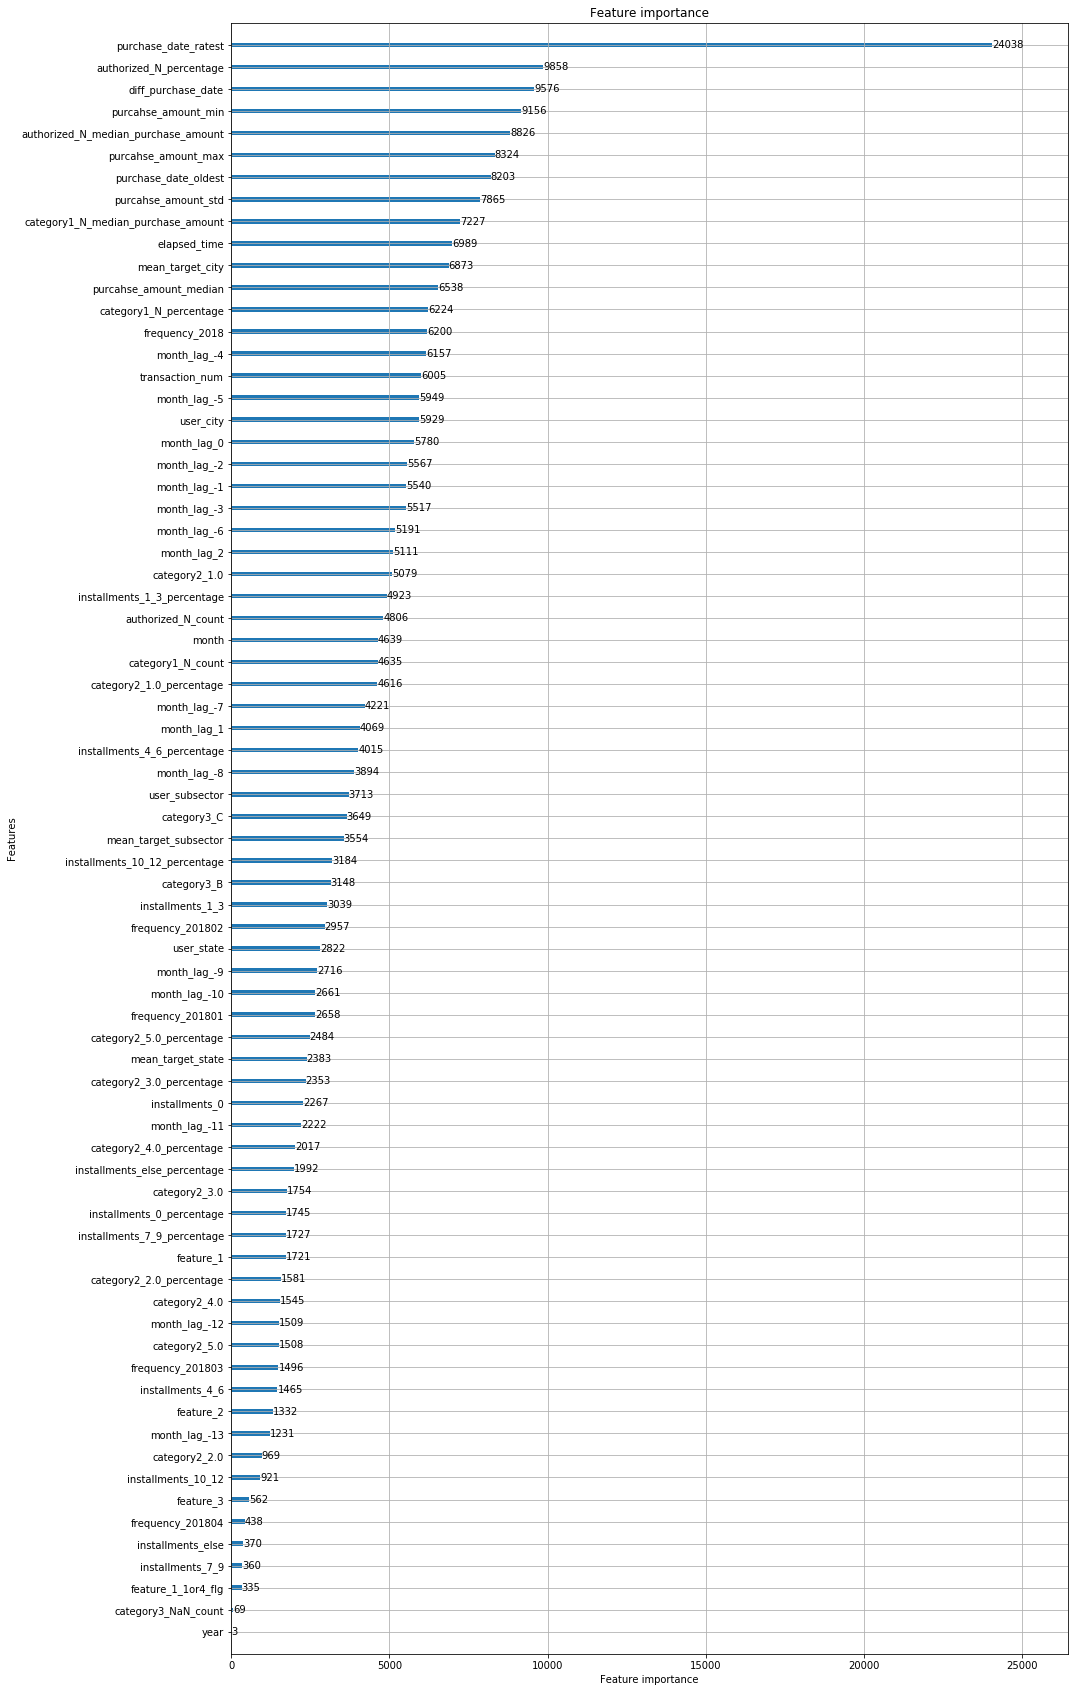

In [133]:
fig, ax = plt.subplots(figsize=(15,30))
lgb.plot_importance(gbm, ax=ax)

In [134]:
predict2 = np.where(predict<-6, -31, predict)

In [138]:
submission = pd.DataFrame({"card_id":raw_test.card_id, "target":predict})
submission.to_csv("./output/submission_20181205_lightgbm.csv", index=False)

- 割り算？
- 2nd ratestを特徴量に追加？

In [86]:
import optuna

def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size=0.25)
    dtrain = lgb.Dataset(X_train, label=Y_train)
    
    num_round = trial.suggest_int('num_round', 1, 1000)
    param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1,
             'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
             'num_leaves': trial.suggest_int('num_leaves', 10, 100),
             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
             }
    
    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    gbm = lgb.train(param, dtrain, num_round)
    preds = gbm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, preds))
    return rmse

study = optuna.create_study()
study.optimize(objective, n_trials=30)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2018-12-05 23:05:25,448] Finished a trial resulted in value: 3.6885308175383202. Current best value is 3.6885308175383202 with parameters: {'num_round': 452, 'boosting': 'gbdt', 'num_leaves': 65, 'learning_rate': 0.0021293226798125646}.
[I 2018-12-05 23:06:09,769] Finished a trial resulted in value: 3.755056165288493. Current best value is 3.6885308175383202 with parameters: {'num_round': 452, 'boosting': 'gbdt', 'num_leaves': 65, 'learning_rate': 0.0021293226798125646}.
[I 2018-12-05 23:07:02,692] Finished a trial resulted in value: 3.807196858330012. Current best value is 3.6885308175383202 with parameters: {'num_round': 452, 'boosting': 'gbdt', 'num_leaves': 65, 'learning_rate': 0.0021293226798125646}.
[I 2018-12-05 23:07:42,380] Finished a trial resulted in value: 3.6988630958397546. Current best value is 3.6885308175383202 with parameters: {'num_round': 452, 'boosting': 'gbdt', 'num_leaves': 65, 'learning_rate': 0.0021293226798125646}.
[I 2018-12-05 23:08:03,466] Finished a tri

KeyboardInterrupt: 